In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import re
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [ ]:
# Config
TRAIN_PATH = 'wnut_16/train.txt'
DEV_PATH = 'wnut_16/dev.txt'
TEST_PATH = 'wnut_16/test.txt'
EMBEDDINGS_PATH = 'wnut_16/glove.twitter.27B.200d.txt'

EMBEDDING_DIM = 200
HIDDEN_DIM = 200
NUM_LAYERS = 2
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 5e-4
DROPOUT = 0.5
WEIGHT_DECAY = 5e-5
CLIP_GRAD = 5.0
CASE_DIM = 3
CASE_PROJ_DIM = 8

In [58]:
# Data Preprocessing
class Indexer:
    """Convert words/tags to indices and vice versa."""
    def __init__(self, elements, is_word_dict=True):
        if is_word_dict:
            self._element_to_index = {"<PAD>": 0, "<UNK>": 1}
        else:
            self._element_to_index = {"<PAD>": 0}
        for x in sorted(set(elements)):
            if x not in self._element_to_index:
                self._element_to_index[x] = len(self._element_to_index)
        self._index_to_element = {v: k for k, v in self._element_to_index.items()}

    def element_to_index(self, element):
        return self._element_to_index.get(element, 1 if "<UNK>" in self._element_to_index else 0)

    def index_to_element(self, index):
        return self._index_to_element.get(index, "<UNK>")

    def elements_to_indices(self, elements):
        return [self.element_to_index(x) for x in elements]

    def indices_to_elements(self, indices):
        return [self.index_to_element(x) for x in indices]

    def size(self):
        return len(self._element_to_index)

    def get_dict(self):
        return self._element_to_index

def clean_text(word):
    """Twitter-style normalization without lowercasing."""
    w = word
    w = re.sub(r"http\S+|www\S+", "<url>", w)
    w = re.sub(r"@\S+", "<user>", w)
    w = re.sub(r"#\S+", "<hashtag>", w)
    return w

def casing_features(original_word):
    """3-dim case features: all_upper / capitalized / mixed."""
    w = original_word
    is_alpha = any(c.isalpha() for c in w)
    if not is_alpha:
        return [0.0, 0.0, 0.0]
    all_upper = 1.0 if w.isupper() else 0.0
    capitalized = 1.0 if (len(w) > 0 and w[0].isupper() and w[1:].islower()) else 0.0
    mixed = 1.0 if (not all_upper and not capitalized and any(c.isupper() for c in w) and any(c.islower() for c in w)) else 0.0
    return [all_upper, capitalized, mixed]

def load_glove_embeddings(path):
    embeddings = {}
    print("Loading GloVe embeddings")
    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f):
            values = line.rstrip().split(' ')
            word = values[0]
            try:
                vector = np.asarray(values[1:], dtype='float32')
                if vector.shape[0] == EMBEDDING_DIM:
                    embeddings[word] = vector
            except:
                continue
    print(f"Loaded {len(embeddings)} word vectors")
    return embeddings

def read_data(path, has_labels=True):
    sentences = []
    sentence = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.strip().split()
                word = parts[0]
                cleaned_word = clean_text(word)
                tag = parts[-1] if has_labels else 'O'
                sentence.append((cleaned_word, tag, word))
    if sentence:
        sentences.append(sentence)
    return sentences

def pad_sequences(sequences, max_len, pad_value=0):
    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [pad_value] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded.append(seq)
    return padded

def pad_feature_sequences(sequences, max_len, feat_dim):
    padded = []
    zero = [0.0] * feat_dim
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [zero] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded.append(seq)
    return padded

def prepare_data(sentences, word_indexer, tag_indexer, max_len):
    X_words, X_case, y = [], [], []
    for sentence in sentences:
        words = [word for word, tag, _ in sentence]
        origs = [orig for _, _, orig in sentence]
        tags = [tag for _, tag, _ in sentence]

        word_indices = word_indexer.elements_to_indices(words)
        case_feats = [casing_features(o) for o in origs]
        tag_indices = tag_indexer.elements_to_indices(tags)

        X_words.append(word_indices)
        X_case.append(case_feats)
        y.append(tag_indices)

    X_words = pad_sequences(X_words, max_len, word_indexer.element_to_index("<PAD>"))
    X_case = pad_feature_sequences(X_case, max_len, CASE_DIM)
    y = pad_sequences(y, max_len, tag_indexer.element_to_index("<PAD>"))

    return np.array(X_words), np.array(X_case, dtype=np.float32), np.array(y)


In [59]:
# CRF
class CRF(nn.Module):
    def __init__(self, num_tags: int, pad_tag_id: int = 0):
        super().__init__()
        self.num_tags = num_tags
        self.pad_tag_id = pad_tag_id
        self.transitions = nn.Parameter(torch.empty(num_tags, num_tags))
        nn.init.uniform_(self.transitions, -0.1, 0.1)
        self.start_transitions = nn.Parameter(torch.empty(num_tags))
        self.end_transitions = nn.Parameter(torch.empty(num_tags))
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        with torch.no_grad():
            self.transitions[:, pad_tag_id] = -1e4
            self.transitions[pad_tag_id, :] = -1e4
            self.start_transitions[pad_tag_id] = -1e4
            self.end_transitions[pad_tag_id] = -1e4

    def _log_sum_exp(self, tensor, dim=-1):
        max_score, _ = tensor.max(dim=dim, keepdim=True)
        return max_score + torch.log(torch.sum(torch.exp(tensor - max_score), dim=dim, keepdim=True))

    def _compute_log_partition(self, emissions, mask):
        B, T, C = emissions.shape
        score = self.start_transitions + emissions[:, 0]
        for t in range(1, T):
            emit_t = emissions[:, t]
            mask_t = mask[:, t].unsqueeze(1)
            score_t = score.unsqueeze(2) + self.transitions.unsqueeze(0) + emit_t.unsqueeze(1)
            score = torch.where(mask_t.bool(), self._log_sum_exp(score_t, dim=1).squeeze(1), score)
        score = score + self.end_transitions
        return self._log_sum_exp(score, dim=1).squeeze(1)

    def _compute_sequence_score(self, emissions, tags, mask):
        B, T, C = emissions.shape
        first_tags = tags[:, 0]
        score = self.start_transitions[first_tags] + emissions[:, 0].gather(1, first_tags.unsqueeze(1)).squeeze(1)
        for t in range(1, T):
            mask_t = mask[:, t]
            prev_tags = tags[:, t - 1]
            curr_tags = tags[:, t]
            trans_score = self.transitions[prev_tags, curr_tags]
            emit_score = emissions[:, t].gather(1, curr_tags.unsqueeze(1)).squeeze(1)
            score = score + (trans_score + emit_score) * mask_t
        last_tag_indices = mask.long().sum(dim=1) - 1
        last_tags = tags.gather(1, last_tag_indices.unsqueeze(1)).squeeze(1)
        score = score + self.end_transitions[last_tags]
        return score

    def forward(self, emissions, tags, mask=None, reduction='sum'):
        if mask is None:
            mask = torch.ones_like(tags, dtype=torch.bool, device=emissions.device)
        mask = mask.bool()
        log_Z = self._compute_log_partition(emissions, mask)
        seq_score = self._compute_sequence_score(emissions, tags, mask)
        log_likelihood = seq_score - log_Z
        if reduction == 'sum':
            return log_likelihood.sum()
        elif reduction == 'mean':
            return log_likelihood.mean()
        return log_likelihood

    def decode(self, emissions, mask=None):
        if mask is None:
            mask = torch.ones(emissions.shape[:2], dtype=torch.bool, device=emissions.device)
        mask = mask.bool()
        B, T, C = emissions.shape
        score = self.start_transitions + emissions[:, 0]
        history = []
        for t in range(1, T):
            emit_t = emissions[:, t]
            mask_t = mask[:, t].unsqueeze(1)
            score_t = score.unsqueeze(2) + self.transitions.unsqueeze(0)
            best_score, best_path = score_t.max(dim=1)
            score = torch.where(mask_t.bool(), best_score + emit_t, score)
            history.append(best_path)
        score = score + self.end_transitions
        seq_ends = mask.long().sum(dim=1) - 1
        best_tags_list = []
        for i in range(B):
            best_last_tag = score[i].argmax().item()
            best_tags = [best_last_tag]
            for back_t in range(len(history) - 1, -1, -1):
                if back_t + 1 > seq_ends[i]:
                    continue
                best_last_tag = history[back_t][i][best_last_tag].item()
                best_tags.append(best_last_tag)
            best_tags.reverse()
            best_tags = best_tags[: seq_ends[i] + 1]
            best_tags_list.append(best_tags)
        return best_tags_list

In [60]:
# Model Structure
class BiLSTM_NER(nn.Module):
    """BiLSTM + CRF with casing features."""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size,
                 pretrained_embeddings=None, dropout=0.4, num_layers=2, pad_tag_id=0,
                 case_dim=CASE_DIM, case_proj_dim=CASE_PROJ_DIM):
        super(BiLSTM_NER, self).__init__()
        self.pad_tag_id = pad_tag_id

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
            self.embedding.weight.requires_grad = False

        self.case_proj = nn.Linear(case_dim, case_proj_dim)

        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(
            embedding_dim + case_proj_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.layernorm = nn.LayerNorm(hidden_dim * 2)
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size)
        self.crf = CRF(num_tags=tagset_size, pad_tag_id=pad_tag_id)

    def emissions(self, sentences, case_feats, lengths=None):
        word_emb = self.embedding(sentences)                      
        case_emb = torch.tanh(self.case_proj(case_feats))         
        x = torch.cat([word_emb, case_emb], dim=-1)               
        x = self.dropout(x)

        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(
                x, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
            lstm_out, _ = self.lstm(packed)
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(
                lstm_out, batch_first=True, total_length=sentences.size(1)
            )
        else:
            lstm_out, _ = self.lstm(x)

        lstm_out = self.layernorm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        tag_space = self.hidden2tag(lstm_out)  
        return tag_space

    def neg_log_likelihood(self, sentences, case_feats, tags, mask, lengths=None, reduction='mean'):
        emit = self.emissions(sentences, case_feats, lengths)
        llh = self.crf(emit, tags, mask=mask, reduction=reduction)
        return -llh

    def decode(self, sentences, case_feats, mask, lengths=None):
        emit = self.emissions(sentences, case_feats, lengths)
        return self.crf.decode(emit, mask=mask)

In [61]:
def create_embedding_matrix(word_indexer, glove_embeddings, embedding_dim):
    vocab_size = word_indexer.size()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    unknown_vector = np.random.randn(embedding_dim) * 0.1
    found = 0
    for word, idx in word_indexer.get_dict().items():
        if word == "<PAD>":
            embedding_matrix[idx] = np.zeros(embedding_dim)
            continue
        key = word.lower()
        if key in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[key]
            found += 1
        else:
            embedding_matrix[idx] = unknown_vector
    print(f"Found embeddings for {found}/{vocab_size} words ({100*found/vocab_size:.2f}%)")
    return embedding_matrix

def get_sequence_lengths(batch_X, pad_idx=0):
    mask = (batch_X != pad_idx).long()
    lengths = mask.sum(dim=1)
    return lengths

def apply_bio_constraints(crf, tag_indexer):
    """Set illegal BIO transitions to a very low score."""
    tags = {i: t for t, i in tag_indexer.get_dict().items()}

    def type_of(t):
        return t.split('-', 1)[1] if '-' in t else None

    with torch.no_grad():
        for i, ti in tags.items():
            for j, tj in tags.items():
                if i == crf.pad_tag_id or j == crf.pad_tag_id:
                    crf.transitions[i, j] = -1e4
                    continue
                if ti.startswith('I-'):
                    crf.start_transitions[i] = -1e4
                if ti == 'O' and tj.startswith('I-'):
                    crf.transitions[i, j] = -1e4
                if (ti.startswith('B-') or ti.startswith('I-')) and tj.startswith('I-'):
                    if type_of(ti) != type_of(tj):
                        crf.transitions[i, j] = -1e4


In [62]:
def evaluate_detailed(model, val_loader, tag_indexer, device):
    model.eval()
    all_predictions = []
    all_true_tags = []

    with torch.no_grad():
        for batch_Xw, batch_Xc, batch_y in val_loader:
            batch_Xw = batch_Xw.to(device)
            batch_Xc = batch_Xc.to(device)
            batch_y  = batch_y.to(device)

            lengths = get_sequence_lengths(batch_Xw)
            mask = (batch_y != 0).to(device)

            pred_paths = model.decode(batch_Xw, batch_Xc, mask=mask, lengths=lengths)
            for i, path in enumerate(pred_paths):
                gold = batch_y[i][mask[i]].tolist()
                pred = path[:len(gold)]
                all_predictions.extend(pred)
                all_true_tags.extend(gold)

    pred_labels = [tag_indexer.index_to_element(p) for p in all_predictions]
    true_labels = [tag_indexer.index_to_element(t) for t in all_true_tags]
    labels = sorted(set(true_labels) - {'<PAD>'})

    precision, recall, f1, support = precision_recall_fscore_support(
        true_labels, pred_labels, labels=labels, average=None, zero_division=0
    )
    macro_precision = float(np.mean(precision)) if len(precision) else 0.0
    macro_recall = float(np.mean(recall)) if len(recall) else 0.0
    macro_f1 = float(np.mean(f1)) if len(f1) else 0.0
    accuracy = (sum(p == t for p, t in zip(pred_labels, true_labels)) / len(pred_labels)) if pred_labels else 0.0

    return {
        'accuracy': accuracy,
        'precision': macro_precision,
        'recall': macro_recall,
        'f1': macro_f1,
        'per_class': {
            label: {'precision': float(p), 'recall': float(r), 'f1': float(f), 'support': int(s)}
            for label, p, r, f, s in zip(labels, precision, recall, f1, support)
        }
    }

In [63]:
def bio_to_spans(tags):
    """Convert BIO tag sequence to spans: (type, start, end_exclusive)."""
    spans = []
    start = None
    ent_type = None
    for i, t in enumerate(tags + ["O"]):
        if t.startswith("B-"):
            if ent_type is not None:
                spans.append((ent_type, start, i))
            ent_type = t.split("-", 1)[1]
            start = i
        elif t.startswith("I-"):
            cur_type = t.split("-", 1)[1]
            if ent_type != cur_type:
                if ent_type is not None:
                    spans.append((ent_type, start, i))
                ent_type = cur_type
                start = i
        else:
            if ent_type is not None:
                spans.append((ent_type, start, i))
                ent_type = None
                start = None
    return spans

def entity_f1(true_tag_seqs, pred_tag_seqs):
    """Micro F1 over exact-match entity spans."""
    tp = fp = fn = 0
    for gold_tags, pred_tags in zip(true_tag_seqs, pred_tag_seqs):
        gold_spans = set(bio_to_spans(gold_tags))
        pred_spans = set(bio_to_spans(pred_tags))
        tp += len(gold_spans & pred_spans)
        fp += len(pred_spans - gold_spans)
        fn += len(gold_spans - pred_spans)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall) else 0.0
    return precision, recall, f1

def evaluate_entity_level(model, loader, tag_indexer, device):
    """Return (precision, recall, f1) on entity-level exact-match spans."""
    model.eval()
    true_tag_seqs, pred_tag_seqs = [], []
    with torch.no_grad():
        for batch_Xw, batch_Xc, batch_y in loader:
            batch_Xw = batch_Xw.to(device)
            batch_Xc = batch_Xc.to(device)
            batch_y  = batch_y.to(device)

            lengths = (batch_Xw != 0).sum(dim=1)
            mask = (batch_y != 0)

            pred_paths = model.decode(batch_Xw, batch_Xc, mask=mask.to(device), lengths=lengths)
            for i, path in enumerate(pred_paths):
                L = lengths[i].item()
                gold_ids = batch_y[i][:L].tolist()
                pred_ids = path[:L]
                gold_tags = [tag_indexer.index_to_element(t) for t in gold_ids]
                pred_tags = [tag_indexer.index_to_element(t) for t in pred_ids]
                gold_tags = [t for t in gold_tags if t != "<PAD>"]
                pred_tags = [t for t in pred_tags if t != "<PAD>"]
                true_tag_seqs.append(gold_tags)
                pred_tag_seqs.append(pred_tags)
    return entity_f1(true_tag_seqs, pred_tag_seqs)

In [64]:
def train_epoch(model, train_loader, optimizer, device, clip_grad=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_Xw, batch_Xc, batch_y in tqdm(train_loader, desc="Training"):
        batch_Xw = batch_Xw.to(device)
        batch_Xc = batch_Xc.to(device)
        batch_y  = batch_y.to(device)

        lengths = get_sequence_lengths(batch_Xw)
        mask = (batch_y != 0).to(device)

        optimizer.zero_grad()
        loss = model.neg_log_likelihood(batch_Xw, batch_Xc, batch_y, mask=mask, lengths=lengths, reduction='mean')
        loss.backward()

        if clip_grad:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        total_loss += loss.item()

        with torch.no_grad():
            pred_paths = model.decode(batch_Xw, batch_Xc, mask=mask, lengths=lengths)
            for i, path in enumerate(pred_paths):
                gold = batch_y[i][mask[i]].tolist()
                pred = path[:len(gold)]
                correct += sum(p == g for p, g in zip(pred, gold))
                total += len(gold)

    return total_loss / len(train_loader), (correct / total if total > 0 else 0.0)

def predict(model, data_loader, device):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for batch_Xw, batch_Xc, batch_y in data_loader:
            batch_Xw = batch_Xw.to(device)
            batch_Xc = batch_Xc.to(device)
            lengths = get_sequence_lengths(batch_Xw)
            mask = (batch_Xw != 0).to(device)
            pred_paths = model.decode(batch_Xw, batch_Xc, mask=mask, lengths=lengths)

            max_len = batch_Xw.size(1)
            padded_preds = []
            for path in pred_paths:
                if len(path) < max_len:
                    path = path + [0] * (max_len - len(path))
                else:
                    path = path[:max_len]
                padded_preds.append(path)
            all_predictions.extend(padded_preds)
    return all_predictions

def write_predictions(sentences, predictions, tag_indexer, output_path):
    with open(output_path, 'w', encoding='utf-8') as f:
        for i, sentence in enumerate(sentences):
            for j, (_, _, original_word) in enumerate(sentence):
                pred_idx = predictions[i][j]
                pred_tag = tag_indexer.index_to_element(pred_idx)
                if pred_tag == "<PAD>":
                    continue
                f.write(f"{original_word} {pred_tag}\n")
            f.write("\n")

def print_metrics(metrics, title="Metrics"):
    print(f"{title:^60}")
    print(f"Accuracy:{metrics['accuracy']:.4f}")
    print(f"Precision:{metrics['precision']:.4f}")
    print(f"Recall:{metrics['recall']:.4f}")
    print(f"F1-Score:{metrics['f1']:.4f}")
    print(f"{'Per-class metrics:':^60}")
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Support':<10}")
    for label, scores in sorted(metrics['per_class'].items()):
        print(f"{label:<15} {scores['precision']:<12.4f} {scores['recall']:<12.4f} "
              f"{scores['f1']:<12.4f} {scores['support']:<10}")

In [65]:
def plot_training(history, save_path=None, show=True):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if "train_acc" in history or "val_acc" in history:
        plt.figure(figsize=(8, 6))
        if "train_acc" in history:
            plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')
        if "val_acc" in history:
            plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker='s')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Using device: cuda
Loading data
Train sentences: 2394
Dev sentences: 1000
Test sentences: 3850
Max sequence length: 41

Building vocabulary
Vocabulary size: 19670
Tag set size: 22
Tags: ['<PAD>', 'B-company', 'B-facility', 'B-geo-loc', 'B-movie', 'B-musicartist', 'B-other', 'B-person', 'B-product', 'B-sportsteam', 'B-tvshow', 'I-company', 'I-facility', 'I-geo-loc', 'I-movie', 'I-musicartist', 'I-other', 'I-person', 'I-product', 'I-sportsteam', 'I-tvshow', 'O']
Loading GloVe embeddings


1193514it [00:56, 21072.68it/s]


Loaded 1193514 word vectors
Preparing data
Creating model
Found embeddings for 16211/19670 words (82.41%)
Total parameters: 5,563,382
Trainable parameters: 1,629,382
Starting training

Epoch 1/30


Training: 100%|██████████| 150/150 [00:31<00:00,  4.77it/s]


Train Loss: 4.5633, Train Acc: 0.9413
Validation Loss: 3.3881, Validation Acc: 0.9375
Validation -> P: 0.4226, R: 0.1074, F1: 0.1713
Best model saved! (Entity F1: 0.1713)

Epoch 2/30


Training: 100%|██████████| 150/150 [00:34<00:00,  4.30it/s]


Train Loss: 2.7842, Train Acc: 0.9528
Validation Loss: 3.1158, Validation Acc: 0.9405
Validation -> P: 0.4571, R: 0.1936, F1: 0.2721
Best model saved! (Entity F1: 0.2721)

Epoch 3/30


Training: 100%|██████████| 150/150 [00:35<00:00,  4.27it/s]


Train Loss: 2.3964, Train Acc: 0.9562
Validation Loss: 2.6091, Validation Acc: 0.9354
Validation -> P: 0.4797, R: 0.2678, F1: 0.3437
Best model saved! (Entity F1: 0.3437)

Epoch 4/30


Training: 100%|██████████| 150/150 [00:34<00:00,  4.33it/s]


Train Loss: 2.1679, Train Acc: 0.9572
Validation Loss: 2.5436, Validation Acc: 0.9396
Validation -> P: 0.4986, R: 0.2784, F1: 0.3573
Best model saved! (Entity F1: 0.3573)

Epoch 5/30


Training: 100%|██████████| 150/150 [00:33<00:00,  4.51it/s]


Train Loss: 2.0410, Train Acc: 0.9596
Validation Loss: 2.5329, Validation Acc: 0.9389
Validation -> P: 0.4734, R: 0.2829, F1: 0.3542
No improvement. Patience: 1/5

Epoch 6/30


Training: 100%|██████████| 150/150 [00:41<00:00,  3.63it/s]


Train Loss: 1.8777, Train Acc: 0.9620
Validation Loss: 2.5747, Validation Acc: 0.9442
Validation -> P: 0.5605, R: 0.2663, F1: 0.3610
Best model saved! (Entity F1: 0.3610)

Epoch 7/30


Training: 100%|██████████| 150/150 [00:35<00:00,  4.24it/s]


Train Loss: 1.7362, Train Acc: 0.9633
Validation Loss: 2.5727, Validation Acc: 0.9451
Validation -> P: 0.5368, R: 0.3086, F1: 0.3919
Best model saved! (Entity F1: 0.3919)

Epoch 8/30


Training: 100%|██████████| 150/150 [00:32<00:00,  4.58it/s]


Train Loss: 1.7018, Train Acc: 0.9646
Validation Loss: 2.4595, Validation Acc: 0.9450
Validation -> P: 0.5255, R: 0.3268, F1: 0.4030
Best model saved! (Entity F1: 0.4030)

Epoch 9/30


Training: 100%|██████████| 150/150 [00:32<00:00,  4.56it/s]


Train Loss: 1.6276, Train Acc: 0.9668
Validation Loss: 2.5060, Validation Acc: 0.9442
Validation -> P: 0.5473, R: 0.2799, F1: 0.3704
No improvement. Patience: 1/5

Epoch 10/30


Training: 100%|██████████| 150/150 [00:32<00:00,  4.61it/s]


Train Loss: 1.4608, Train Acc: 0.9692
Validation Loss: 2.4796, Validation Acc: 0.9455
Validation -> P: 0.5608, R: 0.3207, F1: 0.4081
Best model saved! (Entity F1: 0.4081)

Epoch 11/30


Training: 100%|██████████| 150/150 [00:40<00:00,  3.74it/s]


Train Loss: 1.3873, Train Acc: 0.9695
Validation Loss: 2.4510, Validation Acc: 0.9471
Validation -> P: 0.5130, R: 0.3585, F1: 0.4221
Best model saved! (Entity F1: 0.4221)

Epoch 12/30


Training: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Train Loss: 1.3416, Train Acc: 0.9690
Validation Loss: 2.5285, Validation Acc: 0.9393
Validation -> P: 0.4955, R: 0.3298, F1: 0.3960
No improvement. Patience: 1/5

Epoch 13/30


Training: 100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


Train Loss: 1.2234, Train Acc: 0.9727
Validation Loss: 2.4321, Validation Acc: 0.9474
Validation -> P: 0.5607, R: 0.3495, F1: 0.4306
Best model saved! (Entity F1: 0.4306)

Epoch 14/30


Training: 100%|██████████| 150/150 [00:37<00:00,  4.03it/s]


Train Loss: 1.2267, Train Acc: 0.9733
Validation Loss: 2.5705, Validation Acc: 0.9455
Validation -> P: 0.5398, R: 0.3283, F1: 0.4083
No improvement. Patience: 1/5

Epoch 15/30


Training: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s]


Train Loss: 1.1387, Train Acc: 0.9740
Validation Loss: 2.4078, Validation Acc: 0.9456
Validation -> P: 0.5224, R: 0.3873, F1: 0.4448
Best model saved! (Entity F1: 0.4448)

Epoch 16/30


Training: 100%|██████████| 150/150 [00:41<00:00,  3.61it/s]


Train Loss: 1.0631, Train Acc: 0.9761
Validation Loss: 2.6404, Validation Acc: 0.9485
Validation -> P: 0.5444, R: 0.3525, F1: 0.4279
No improvement. Patience: 1/5

Epoch 17/30


Training: 100%|██████████| 150/150 [00:35<00:00,  4.20it/s]


Train Loss: 0.9862, Train Acc: 0.9773
Validation Loss: 2.7962, Validation Acc: 0.9485
Validation -> P: 0.5678, R: 0.3359, F1: 0.4221
No improvement. Patience: 2/5

Epoch 18/30


Training: 100%|██████████| 150/150 [00:39<00:00,  3.76it/s]


Train Loss: 0.9377, Train Acc: 0.9786
Validation Loss: 2.4860, Validation Acc: 0.9471
Validation -> P: 0.5253, R: 0.3767, F1: 0.4388
No improvement. Patience: 3/5

Epoch 19/30


Training: 100%|██████████| 150/150 [00:38<00:00,  3.91it/s]


Train Loss: 0.8400, Train Acc: 0.9804
Validation Loss: 2.6394, Validation Acc: 0.9473
Validation -> P: 0.5423, R: 0.3585, F1: 0.4317
No improvement. Patience: 4/5

Epoch 20/30


Training: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s]


Train Loss: 0.7523, Train Acc: 0.9813
Validation Loss: 2.6656, Validation Acc: 0.9493
Validation -> P: 0.5418, R: 0.4024, F1: 0.4618
Best model saved! (Entity F1: 0.4618)

Epoch 21/30


Training: 100%|██████████| 150/150 [00:38<00:00,  3.87it/s]


Train Loss: 0.6976, Train Acc: 0.9834
Validation Loss: 2.6906, Validation Acc: 0.9472
Validation -> P: 0.5212, R: 0.3903, F1: 0.4464
No improvement. Patience: 1/5

Epoch 22/30


Training: 100%|██████████| 150/150 [00:40<00:00,  3.70it/s]


Train Loss: 0.6509, Train Acc: 0.9839
Validation Loss: 2.8543, Validation Acc: 0.9444
Validation -> P: 0.5353, R: 0.3782, F1: 0.4433
No improvement. Patience: 2/5

Epoch 23/30


Training: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]


Train Loss: 0.6697, Train Acc: 0.9835
Validation Loss: 2.7788, Validation Acc: 0.9451
Validation -> P: 0.5210, R: 0.3933, F1: 0.4483
No improvement. Patience: 3/5

Epoch 24/30


Training: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s]


Train Loss: 0.5968, Train Acc: 0.9849
Validation Loss: 2.8583, Validation Acc: 0.9492
Validation -> P: 0.5567, R: 0.4009, F1: 0.4661
Best model saved! (Entity F1: 0.4661)

Epoch 25/30


Training: 100%|██████████| 150/150 [00:34<00:00,  4.38it/s]


Train Loss: 0.5707, Train Acc: 0.9849
Validation Loss: 2.9161, Validation Acc: 0.9505
Validation -> P: 0.5761, R: 0.4009, F1: 0.4728
Best model saved! (Entity F1: 0.4728)

Epoch 26/30


Training: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


Train Loss: 0.5587, Train Acc: 0.9861
Validation Loss: 2.9275, Validation Acc: 0.9463
Validation -> P: 0.5406, R: 0.3828, F1: 0.4482
No improvement. Patience: 1/5

Epoch 27/30


Training: 100%|██████████| 150/150 [00:39<00:00,  3.82it/s]


Train Loss: 0.5408, Train Acc: 0.9866
Validation Loss: 2.9774, Validation Acc: 0.9501
Validation -> P: 0.5584, R: 0.3903, F1: 0.4595
No improvement. Patience: 2/5

Epoch 28/30


Training: 100%|██████████| 150/150 [00:33<00:00,  4.52it/s]


Train Loss: 0.5292, Train Acc: 0.9866
Validation Loss: 2.9081, Validation Acc: 0.9464
Validation -> P: 0.5307, R: 0.3918, F1: 0.4508
No improvement. Patience: 3/5

Epoch 29/30


Training: 100%|██████████| 150/150 [00:35<00:00,  4.28it/s]


Train Loss: 0.5335, Train Acc: 0.9867
Validation Loss: 2.9661, Validation Acc: 0.9497
Validation -> P: 0.5618, R: 0.3918, F1: 0.4617
No improvement. Patience: 4/5

Epoch 30/30


Training: 100%|██████████| 150/150 [00:35<00:00,  4.22it/s]


Train Loss: 0.4791, Train Acc: 0.9863
Validation Loss: 2.9568, Validation Acc: 0.9500
Validation -> P: 0.5602, R: 0.4085, F1: 0.4724
No improvement. Patience: 5/5
Early stopping triggered


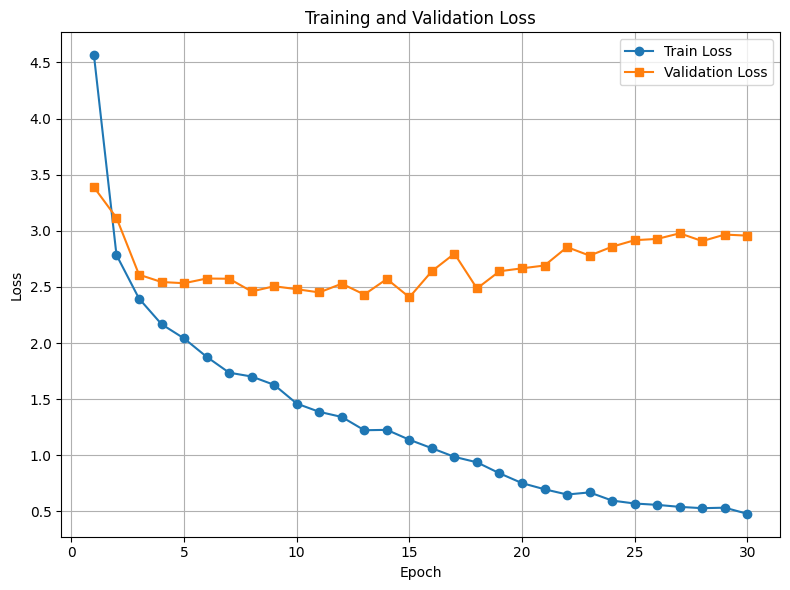

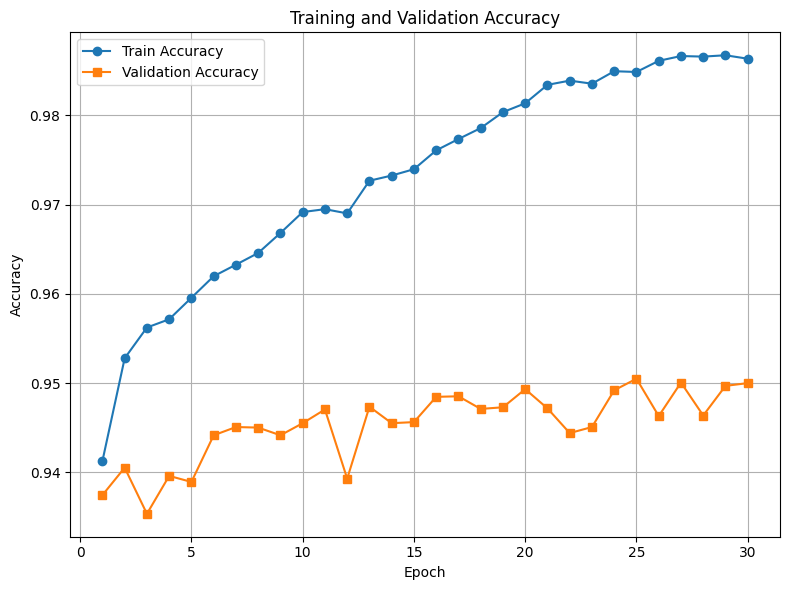

Loading best model for final evaluation

              Final Validation (Entity-level)               

Precision: 0.5761  Recall: 0.4009  F1: 0.4728
Generating test predictions
Predictions saved to result.txt
Training completed


In [ ]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    print("Loading data")
    train_sentences = read_data(TRAIN_PATH)
    dev_sentences = read_data(DEV_PATH)
    test_sentences = read_data(TEST_PATH, has_labels=False)
    print(f"Train sentences: {len(train_sentences)}")
    print(f"Dev sentences: {len(dev_sentences)}")
    print(f"Test sentences: {len(test_sentences)}")

    max_len = max(
        max(len(s) for s in train_sentences),
        max(len(s) for s in dev_sentences),
        max(len(s) for s in test_sentences)
    )
    print(f"Max sequence length: {max_len}")

    # Build vocabulary from train/dev/test tokens
    print("\nBuilding vocabulary")
    all_words = set()
    all_tags = set()
    for sents in [train_sentences, dev_sentences, test_sentences]:
        for sentence in sents:
            for word, tag, _ in sentence:
                all_words.add(word)
                all_tags.add(tag)
    word_indexer = Indexer(all_words, is_word_dict=True)
    tag_indexer = Indexer(all_tags, is_word_dict=False)

    print(f"Vocabulary size: {word_indexer.size()}")
    print(f"Tag set size: {tag_indexer.size()}")
    print(f"Tags: {sorted(tag_indexer.get_dict().keys())}")

    glove_embeddings = load_glove_embeddings(EMBEDDINGS_PATH)

    # Prepare arrays
    print("Preparing data")
    train_Xw, train_Xc, train_y = prepare_data(train_sentences, word_indexer, tag_indexer, max_len)
    dev_Xw, dev_Xc, dev_y = prepare_data(dev_sentences, word_indexer, tag_indexer, max_len)
    test_Xw, test_Xc, test_y = prepare_data(test_sentences, word_indexer, tag_indexer, max_len)

    train_dataset = torch.utils.data.TensorDataset(
        torch.LongTensor(train_Xw), torch.FloatTensor(train_Xc), torch.LongTensor(train_y)
    )
    dev_dataset = torch.utils.data.TensorDataset(
        torch.LongTensor(dev_Xw), torch.FloatTensor(dev_Xc), torch.LongTensor(dev_y)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.LongTensor(test_Xw), torch.FloatTensor(test_Xc), torch.LongTensor(test_y)
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True
    )
    dev_loader = torch.utils.data.DataLoader(
        dev_dataset, batch_size=BATCH_SIZE
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=BATCH_SIZE
    )

    # Create model
    print("Creating model")
    embedding_matrix = create_embedding_matrix(word_indexer, glove_embeddings, EMBEDDING_DIM)
    model = BiLSTM_NER(
        vocab_size=word_indexer.size(),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        tagset_size=tag_indexer.size(),
        pretrained_embeddings=embedding_matrix,
        dropout=DROPOUT,
        num_layers=NUM_LAYERS,
        pad_tag_id=0
    ).to(device)

    apply_bio_constraints(model.crf, tag_indexer)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # AdamW param 
    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if n.endswith(".bias") or "norm" in n.lower() or "crf.transitions" in n or "start_transitions" in n or "end_transitions" in n:
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [{"params": decay, "weight_decay": WEIGHT_DECAY},
         {"params": no_decay, "weight_decay": 0.0}],
        lr=LEARNING_RATE
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )

    # Training loop with entity-level F1 as the key metric
    print("Starting training")
    best_f1 = 0.0
    patience_counter = 0
    max_patience = 5

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss":[],
        "val_acc":[],
        "ent_f1": [],
        "lr": []
    }

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, device, CLIP_GRAD
        )
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_Xw, batch_Xc, batch_y in dev_loader:
                batch_Xw = batch_Xw.to(device)
                batch_Xc = batch_Xc.to(device)
                batch_y = batch_y.to(device)
                lengths = get_sequence_lengths(batch_Xw)
                mask = (batch_y != 0).to(device)

                # Compute validation loss
                loss = model.neg_log_likelihood(batch_Xw, batch_Xc, batch_y, mask=mask, lengths=lengths, reduction='mean')
                total_val_loss += loss.item()

                # Compute token-level accuracy
                pred_paths = model.decode(batch_Xw, batch_Xc, mask=mask, lengths=lengths)
                for i, path in enumerate(pred_paths):
                    gold = batch_y[i][mask[i]].tolist()
                    pred = path[:len(gold)]
                    correct_val += sum(p == g for p, g in zip(pred, gold))
                    total_val += len(gold)

        val_loss = total_val_loss / len(dev_loader)
        val_acc = correct_val / total_val if total_val > 0 else 0.0

        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        p_ent, r_ent, f1_ent = evaluate_entity_level(model, dev_loader, tag_indexer, device)
        print(f"Validation -> P: {p_ent:.4f}, R: {r_ent:.4f}, F1: {f1_ent:.4f}")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["ent_f1"].append(f1_ent)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        scheduler.step(f1_ent)

        if f1_ent > best_f1:
            best_f1 = f1_ent
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, 'best_model.pth')
            print(f"Best model saved! (Entity F1: {best_f1:.4f})")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{max_patience}")
            if patience_counter >= max_patience:
                print("Early stopping triggered")
                break

    # Plot curves after training
    plot_training(history, save_path="training_curves.png")

    print("Loading best model for final evaluation")
    checkpoint = torch.load('best_model.pth', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Final report
    p_ent, r_ent, f1_ent = evaluate_entity_level(model, dev_loader, tag_indexer, device)
    print(f"\n{'Final Validation (Entity-level)':^60}\n")
    print(f"Precision: {p_ent:.4f}  Recall: {r_ent:.4f}  F1: {f1_ent:.4f}")

    final_metrics = evaluate_detailed(model, dev_loader, tag_indexer, device)
    print_metrics(final_metrics, "Final Validation (Token-level Detailed)")

    # Test predictions
    print("Generating test predictions")
    test_predictions = predict(model, test_loader, device)
    write_predictions(test_sentences, test_predictions, tag_indexer, 'result.txt')
    print("Predictions saved to result.txt")
    print("Training completed")

if __name__ == "__main__":
    main()